In [4]:
import argparse, os, sys, glob, cv2
from os import path
from base64 import b64encode
from PIL import Image, ImageDraw
from IPython.display import HTML

import numpy as np
import torch
from torch import autocast, float16
from torch.nn import functional as F

from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler

from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

from base64 import b64encode
# from IPython.display import HTML

device = 'cuda'

cwd = path.join(os.getcwd())
modelpath = 'models/ldm/stable-diffusion-v1'
loadpath = path.normpath(path.join(cwd, '..', modelpath))

# print(loadpath)


/home/finn/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained('/home/finn/data/stable-diffusion-v1-4/vae')
vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained('/home/finn/data/stable-diffusion-v1-4/tokenizer')
text_encoder = CLIPTextModel.from_pretrained('/home/finn/data/stable-diffusion-v1-4/text_encoder')
text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained('/home/finn/data/stable-diffusion-v1-4/unet')
unet.to(device)


# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule='scaled_linear',
    num_train_timesteps=1000
)

In [6]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, 
      padding='max_length', 
      max_length=tokenizer.model_max_length,
      truncation=True, 
      return_tensors='pt'
    )

  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings


In [8]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents).sample

  imgs = (imgs + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Imamake_video copyge.fromarray(image) for image in imgs]
  return pil_images


# similars

In [25]:
def perturb_latents(latents, scale=0.1):
    noise = torch.randn_like(latents)
    new_latents = (1 - scale) * latents + scale * noise
    return (new_latents - new_latents.mean()) / new_latents.std()

20it [00:01, 10.54it/s]
100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


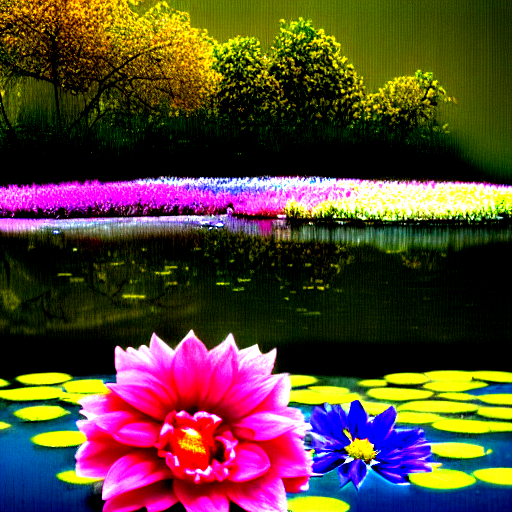

In [39]:
new_prompt = 'flowers on a pond, squid, bright, cyberpunk'
new_latents = perturb_latents(latents, 0.4)
img = prompt_to_images(new_prompt, num_inference_steps=20, latents=new_latents)[0]
img

# image to image

50it [00:04, 10.36it/s]
100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


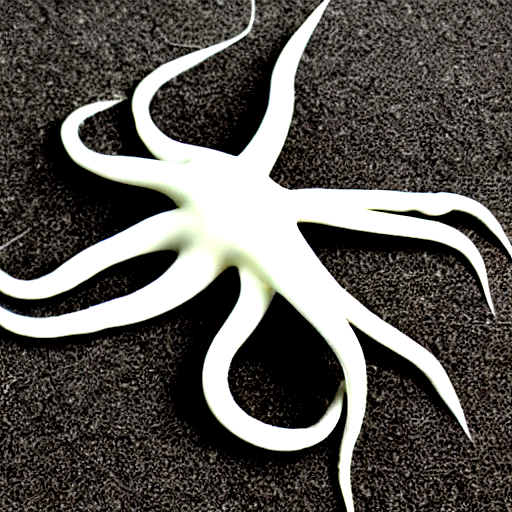

In [40]:
prompt = 'upright squid' 
img = prompt_to_images(prompt, num_inference_steps=50)[0]
img

In [50]:
def encode_image_latents(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    img_arr = np.stack([np.array(img) for img in imgs], axis=0)
    img_arr = img_arr / 255.0
    img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
    img_arr = 2 * (img_arr - 0.5)

    latent_dists = vae.encode(img_arr.to(device)) 
    latent_samples = latent_dists.latent_dist.sample()
    latent_samples *= 0.18215

    return latent_samples


In [51]:
img_latents = encode_image_latents([img])
img_latents

tensor([[[[-1.3921e+00, -6.5809e-01, -1.9010e+00,  ..., -1.8508e+00,
           -1.0630e-01, -1.5622e+00],
          [-2.6808e-01, -1.4015e+00,  1.5171e-02,  ..., -2.5963e-02,
           -1.2916e+00, -1.9613e-02],
          [-1.1688e+00, -4.9282e-01, -8.9523e-01,  ..., -1.0453e+00,
           -1.0025e+00, -3.3372e-01],
          ...,
          [-9.1556e-01, -2.1153e+00, -1.2711e+00,  ..., -1.1107e+00,
           -1.9935e+00, -9.8606e-01],
          [-8.5189e-01, -1.1539e+00, -9.4687e-01,  ..., -1.3626e+00,
            3.5516e-01, -2.9243e-01],
          [-1.2437e+00, -9.0264e-04, -1.0976e+00,  ..., -1.1775e+00,
           -7.4422e-01, -1.2993e+00]],

         [[-7.2105e-01, -7.2317e-01, -9.9113e-02,  ...,  1.5053e+00,
           -1.4742e-01, -1.1012e-01],
          [-2.9131e-01, -1.6635e-01, -1.0675e+00,  ..., -3.5525e-01,
            1.5723e-01, -1.7438e-01],
          [-3.3027e-01, -9.0328e-01,  4.2365e-01,  ..., -1.3456e-01,
           -3.8890e-01, -1.0406e+00],
          ...,
     

In [ ]:
def produce_latents(
    text_embeddings, 
    height = 512,
    width = 512,
    num_inference_steps=50,
    guidance_scale=7.5,
    latents=None,
    return_all_latents=False,
    start_step=10
):
    if latents is None:
        latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, height // 8, width // 8))
    latents = latents.to(device)

In [1]:
def prompt_to_images():

SyntaxError: unexpected EOF while parsing (2671742782.py, line 1)